In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import medmnist
from medmnist import INFO, Evaluator

# Data Preparation

In [2]:
print(medmnist.__version__)
# note there is also mednist+!!

3.0.2


paper: https://arxiv.org/pdf/2502.13056

In [3]:
from medmnist import PneumoniaMNIST

dataset = PneumoniaMNIST
dataset

medmnist.dataset.PneumoniaMNIST

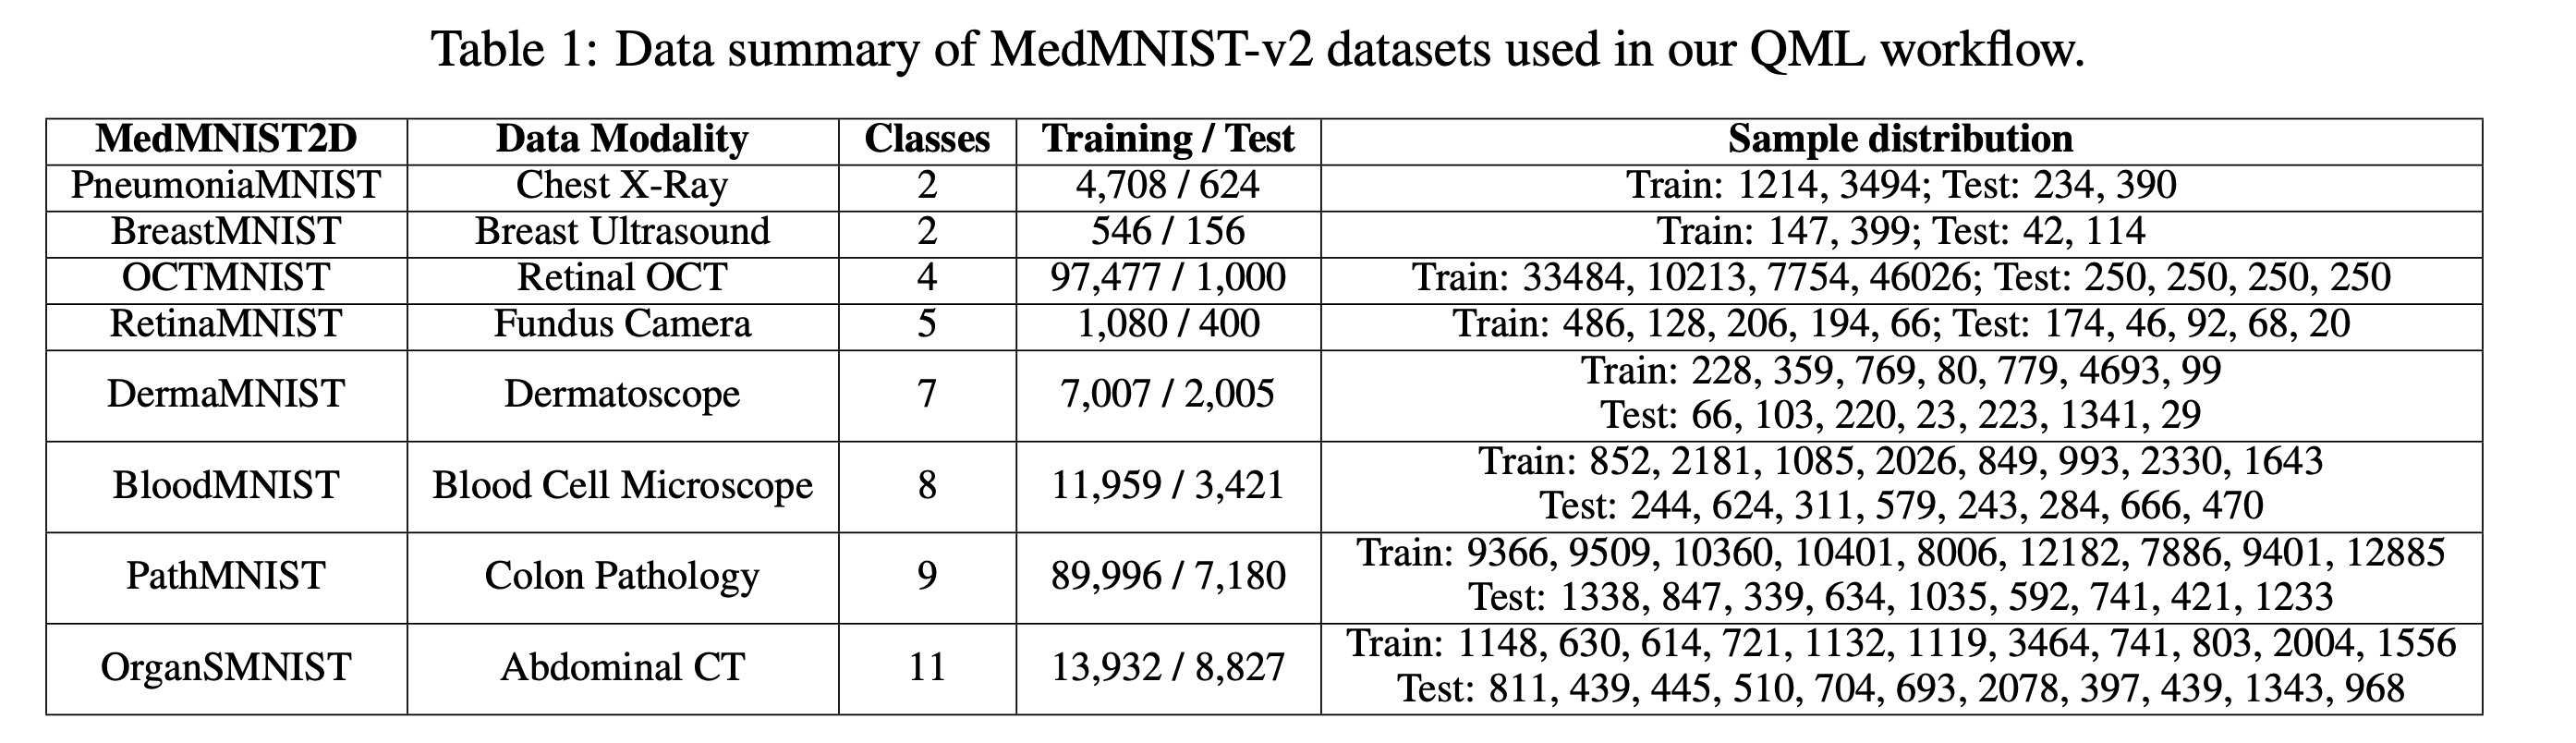

They claim quantum advantage in the case of the retina datset. Yet only when they down sample the input features of the classical model due to quantum constraints. Using no constraints on the classical model, the model outperformed the quantum model. 

In [5]:
from medmnist import BreastMNIST

train_dataset = BreastMNIST(split='train', download=True)
test_dataset  = BreastMNIST(split='test', download=True)

100%|██████████| 559580/559580 [00:00<00:00, 7976321.77it/s]

Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz


In [6]:
train_dataset

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /Users/ramonwinkler/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0

In [8]:
print(type(train_dataset))

<class 'medmnist.dataset.BreastMNIST'>


In [10]:
train_dataset.info

{'python_class': 'BreastMNIST',
 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1',
 'MD5': '750601b1f35ba3300ea97c75c52ff8f6',
 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1',
 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364',
 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1',
 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1',
 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1',
 'MD5_224

Note: normal + benign are combined into one class: benign!

In [12]:
print(len(train_dataset))

546


## Convert medmnist datset object into pandas dataframe

In [ ]:
# save images and labels in a list
images = []
labels = []

for img, label in train_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [21]:
# create a df of the extracted data
train_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [22]:
train_df.head()

,image,label
0,"[[139, 139, 138, 139, 142, 149, 156, 159, 164,...",1
1,"[[82, 85, 83, 78, 76, 76, 79, 79, 76, 80, 86, ...",1
2,"[[157, 155, 151, 145, 149, 146, 141, 134, 141,...",1
3,"[[167, 163, 162, 151, 145, 133, 139, 149, 150,...",1
4,"[[1, 6, 41, 79, 159, 180, 175, 175, 175, 181, ...",0


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   546 non-null    object
 1   label   546 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [25]:
train_df["label"].value_counts()

label
1    399
0    147
Name: count, dtype: int64

imbalance!

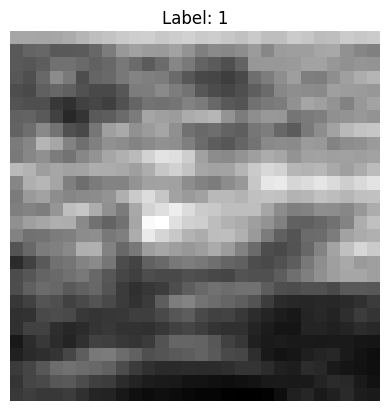

In [27]:
# define a sample
sample = train_df.iloc[0]

img_np = sample["image"] 
label  = sample["label"]

plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [32]:
print("shape:",img_np.shape)

shape: (28, 28)


image is an np.array

## Define a simple classical CNN

In [34]:
# create a CNN class
class CNN(nn.Module):
    def __init__(self, in_channels):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [39]:
# device definition: gpu/ cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [40]:
# define hyperparameters
n_channels = n_channels = 1 # images are grayscale: each pixel has 1 channel!
nput_size = 784  # 28x28 pixels 
num_classes = 2 # define the number of classes (benign, malignant)
learning_rate = 0.001 # artificial, think about adjusting!
batch_size = 64
num_epochs = 500

check number of epochs, batch_size, learning rate!

In [41]:
# create an instance of the cnn class
model = CNN(in_channels=n_channels)

In [43]:
# define loss strategy and optimizer
criterion = nn.CrossEntropyLoss()
    
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # adam optimizes model.parameters!

check different criterion!

opimizier casually set to adam, because it always works
momentum can be defined! other tunings for hyperparameters??

## Transform training data to torch tensors for CNN input

In [ ]:
# Extract features and labels from DataFrame
X = np.stack(train_df['image'].values)      # shape (N, 28, 28)
y = np.array(train_df['label'].values)      # shape (N,)

## Training

In [48]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")

    # Shuffle indices each epoch
    perm = torch.randperm(num_samples)

    for i in range(0, num_samples, batch_size):
        indices = perm[i:i+batch_size]
        data = X_tensor[indices]      # shape (batch_size, 1, 28, 28)
        targets = y_tensor[indices]   # shape (batch_size,)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch [1/500]


NameError: name 'num_samples' is not defined